# Introduction

Road safety is a very important topic around the world, and in the United Kingdom it's no different. Each year thousands of accidents are reported to the police and details such as location, date, weather, road conditions, and number of causalities are recorded. There are three datasets to be analyzed: Accident information from 2017, Casualty information from 2017, and Vehicle information from 2017. These files are freely available for download on data.gov.uk. The goal is to make roads safer for everyone by digging into common denominators and using visualization to make sense of the data.

The following notebook uses pyspark and pandas to manipulate the data, using matplotlib and seaborn to vizualize the results. While these aren't "big data" files that require processing over a cluster, this serves as an example of how you would leverage big data tools on similar datasets. 

## Import Packages

In [46]:
#import necessary packages
import pyspark, os, zipfile
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt

## Create sql and spark context to work with pyspark

In [ ]:
#import necessary packages
from pyspark.sql import SQLContext
from pyspark import SparkContext

#create spark context
sc = SparkContext("local", "accident_analysis")

#create sql context
sqlCtx = SQLContext(sc)

## Download files from data.gov.uk 

(Files are included on github page if you're out of the country and can't access the website.)

In [17]:
#use urllib to download files

#get accident data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2017.zip',
                          'C:/Users/ianke/Desktop/accidents.zip')

#get casualty data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2017.zip',
                          'C:/Users/ianke/Desktop/casualties.zip')

#get vehicle data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2017.zip',
                          'C:/Users/ianke/Desktop/vehicle.zip')

#get data dictionary info
urllib.request.urlretrieve('http://data.dft.gov.uk/road-accidents-safety-data/Road-Accident-Safety-Data-Guide.xls',
                          'C:/Users/ianke/Desktop/dictionary.xls')

('C:/Users/ianke/Desktop/dictionary.xls',
 <http.client.HTTPMessage at 0x1af0c0d0160>)

## Unzip the downloaded files and extract the .csv data files

In [19]:
#unzip accident data
accidentZip = zipfile.ZipFile('C:/Users/ianke/Desktop/accidents.zip', 'r')
accidentZip.extractall('C:/Users/ianke/Desktop/')
accidentZip.close()

#unzip casualty data
casualtyZip = zipfile.ZipFile('C:/Users/ianke/Desktop/casualties.zip', 'r')
casualtyZip.extractall('C:/Users/ianke/Desktop/')
casualtyZip.close()

#unzip vehicle data
casualtyZip = zipfile.ZipFile('C:/Users/ianke/Desktop/vehicle.zip', 'r')
casualtyZip.extractall('C:/Users/ianke/Desktop/')
casualtyZip.close()

## Delete the unnecessary zip files

In [22]:
#delete zip folders
os.remove('C:/Users/ianke/Desktop/accidents.zip')
os.remove('C:/Users/ianke/Desktop/casualties.zip')
os.remove('C:/Users/ianke/Desktop/vehicle.zip')

## Fix a header in the "accidents" csv

In a later query having the parenthesis in the column header caused some problems.

In [23]:
#read in csv
headerfix = pd.read_csv("C:/Users/ianke/Desktop/Acc.csv", low_memory=False)

#change header name
headerfix = headerfix.rename(columns={'Local_Authority_(District)': 'Local_Authority_District'})

#output csv
headerfix.to_csv("C:/Users/ianke/Desktop/Acc.csv", index=False)

## Create spark dataframes to enable spark.sql querying

These dataframes will be directly queried when analyzing and vizualizing the data. 

In [41]:
#create accidents Spark dataframe
accidents = sqlCtx.read.option("header","true").csv("C:/Users/ianke/Desktop/Acc.csv")

#create casualties Spark dataframe
casualties = sqlCtx.read.option("header","true").csv("C:/Users/ianke/Desktop/Cas.csv")

#create vehicles Spark dataframe
vehicles = sqlCtx.read.option("header","true").csv("C:/Users/ianke/Desktop/Veh.csv")

## Create a dictionary object 

The dictionary object can reference each column description tab in the original .xls file. 

In [36]:
#create dictionary variable
dictionary = pd.ExcelFile('C:/Users/ianke/Desktop/dictionary.xls')

#create police force dictionary by specifying the tab of the dictionary variable
policeForcePD = pd.read_excel(dictionary, 'Police Force')

#convert to spark dataframe
policeForce = sqlCtx.createDataFrame(policeForcePD)

# Data Exploration

The following section outlines different queries and vizualizations I used to explore the data. There isn't really a method to my madness, I just created queries I thought might be interesting. 

## Find the top 5 local authorities with the most fatal accidents

In [73]:
#create local authority dictionary by specifying the tab in the dictionary variable
localAuthorityPD = pd.read_excel(dictionary, 'Local Authority (District)')

#convert to spark dataframe
localAuthority = sqlCtx.createDataFrame(localAuthorityPD)

#join accidents and localAuthority dataframes and group by local authority
top5 = accidents.join(localAuthority, accidents.Local_Authority_District == localAuthority.code, "left_outer") \
                .select((localAuthority.label).alias("local_authority_district")) \
                .where(accidents.Accident_Severity == 1) \
                .groupby("local_authority_district").count().withColumnRenamed("count", "number_of_fatal") \
                .orderBy("number_of_fatal", ascending=False) \
                .limit(5)

#output final query
top5 = top5.toPandas()

## Vizualize most fatal accidents by top 5 local authorities

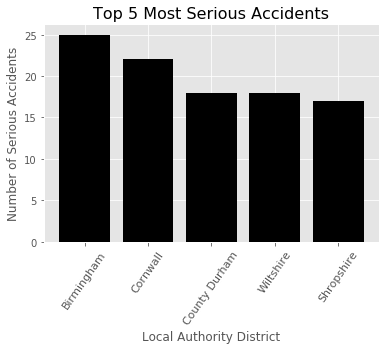

In [88]:
#create bar chart
plt.bar(top5.local_authority_district, height=top5.number_of_fatal, color='black')
plt.xlabel('Local Authority District')
plt.ylabel('Number of Serious Accidents')
plt.title('Top 5 Most Serious Accidents', fontdict = {'fontsize' : 16})
plt.style.use('ggplot')
plt.xticks(rotation=55, fontsize=11)
plt.show()

## Create Vehicle Type Dictionary

In [94]:
#create vehicle type dictionary by specifying the tab
vehicleTypePD = pd.read_excel(dictionary, 'Vehicle Type')

#convert to spark dataframe
vehicleType = sqlCtx.createDataFrame(vehicleTypePD)

## Rank vehicle types that were involved in fatal or serious accidents

In [101]:
#join the accidents dataframe and the vehicleType dictionary dataframe to vehicles & filter by accident severity
topVehicles = vehicles.join(accidents, "Accident_Index", "inner") \
                      .join(vehicleType, vehicles.Vehicle_Type == vehicleType.code, "left_outer") \
                      .select((vehicleType.label).alias("vehicle_type")) \
                      .where(((accidents.Accident_Severity == 1) | (accidents.Accident_Severity == 2)) & (vehicleType.label != "Data missing or out of range")) \
                      .groupby("vehicle_type").count().withColumnRenamed("count", "serious_and_fatal_accidents") \
                      .orderBy("Serious_and_Fatal_Accidents", ascending=False)

#output final query
topVehicles = topVehicles.toPandas()

## Vizualize which vehicle types are involved in the most accidents

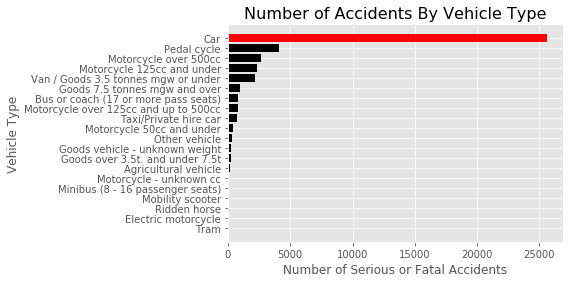

In [102]:
#reverse order so max is on top
topVehicles = topVehicles[::-1]

#add colors to highlight maximum column 
colors = ['black'] * 20
colors[19] = 'red'

#create bar chart (horizontal to fit the long label information)
plt.barh(topVehicles.vehicle_type, width=topVehicles.serious_and_fatal_accidents, color=colors)
plt.xlabel('Number of Serious or Fatal Accidents')
plt.ylabel('Vehicle Type')
plt.title('Number of Accidents By Vehicle Type', fontdict = {'fontsize' : 16})
plt.style.use('ggplot')
plt.show()